In [1]:
from dataclasses import dataclass
from typing import Callable
from datetime import datetime

@dataclass
class CONFIGURATION:
  MODEL: str
  hp_subsample: float
  hp_tries: int
  hp_space_fun: Callable
  train_p: int = 0.6
  valid_p: int = 0.2
  test_p: int = 0.2
  set_pad_token: bool = False
  train_subsample: float = 1
  model_name_suffix: str = ''
  head_discriminator: str = ''
  resample = None

In [3]:
# Configurations definitions

def distilroberta_hp_space(MODEL_DIR):
  def hp_space(trial):
    return {        
      "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1e-4, log=True),
      "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 16]),  
      "logging_dir": f'{MODEL_DIR}/runs/{trial.number:03d}'
    }
  return hp_space

def distilroberta_partial_hp_space(MODEL_DIR):
  def hp_space(trial):
    return {        
      "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1e-4, log=True),
      "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [1, 16, 64, 128]),  
      "logging_dir": f'{MODEL_DIR}/runs/{trial.number:03d}'
    }
  return hp_space

def distilgpt2_hp_space(MODEL_DIR):
  def hp_space(trial):
    return {        
      "learning_rate": trial.suggest_float("learning_rate", 1e-7, 1e-4, log=True),
      "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4]),  
      "logging_dir": f'{MODEL_DIR}/runs/{trial.number:03d}'
    }
  return hp_space

distilroberta_full_config = CONFIGURATION(
  MODEL = 'distilbert/distilroberta-base',
  hp_subsample=.2,
  hp_space_fun=distilroberta_hp_space,
  hp_tries=20,
  train_p=0.6,
  valid_p=0.2,
  test_p=0.2,
  set_pad_token=False,
  train_subsample=None,
)

distilroberta_partial_config = CONFIGURATION(
  MODEL = 'distilbert/distilroberta-base',
  hp_subsample=.2,
  hp_space_fun=distilroberta_partial_hp_space,
  hp_tries=25,
  train_p=0.6,
  valid_p=0.2,
  test_p=0.2,
  set_pad_token=False,
  train_subsample=None,
  model_name_suffix='_partial',
  head_discriminator='classifier'
)

distilgpt2_full_config = CONFIGURATION(
  MODEL = 'distilbert/distilgpt2',
  hp_subsample=.2,
  hp_space_fun=distilgpt2_hp_space,
  hp_tries=10,
  train_p=0.6,
  valid_p=0.2,
  test_p=0.2,
  set_pad_token=True,
  train_subsample=None,
)

distilgpt2_partial_config = CONFIGURATION(
  MODEL = 'distilbert/distilgpt2',
  hp_subsample=.2,
  hp_space_fun=distilgpt2_hp_space,
  hp_tries=10,
  train_p=0.6,
  valid_p=0.2,
  test_p=0.2,
  set_pad_token=True,
  train_subsample=None,
  model_name_suffix='_partial',
  head_discriminator='ln_f'
)

test_gpt = CONFIGURATION(
  MODEL = 'distilbert/distilgpt2',
  hp_subsample=.0008,
  hp_space_fun=distilgpt2_hp_space,
  hp_tries=10,
  train_p=0.6,
  valid_p=0.2,
  test_p=0.2,
  set_pad_token=True,
  train_subsample=0.1,
  model_name_suffix='_partial',
  head_discriminator='ln_f'
)

distilroberta_full_resampled = distilroberta_full_config
distilroberta_full_resampled.model_name_suffix = '_resampled'
distilroberta_full_resampled.hp_tries = 12
distilroberta_full_resampled.resample = {
  'pop': 1,
  'rb': 0.75,
  'rock': 0.75,
  'country': 0.5,
  'rap': 0.5,
}


# Change this to select from one of the configurations above
CONFIG = distilroberta_full_resampled



MODEL_NAME = CONFIG.MODEL + CONFIG.model_name_suffix
MODEL_DIR = '../NAS/' + MODEL_NAME + '/' + str(datetime.now())
CONFIG.hp_space_fun = CONFIG.hp_space_fun(MODEL_DIR)


In [4]:
import pandas as pd
import mapply
mapply.init(progressbar=True, max_chunks_per_worker=100)

/home/hlt/HLT_PROJECT/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Dataset loading

clean = pd.read_feather('../data/lyrics_cleaned.feather')
clean = clean[clean['tag'] != 'misc']

if CONFIG.resample:
  tmp_resampled = []
  for tag in CONFIG.resample:
    tmp_resampled += [clean[clean['tag'] == tag].sample(frac=CONFIG.resample[tag])]
  clean = pd.concat(tmp_resampled)

In [11]:
# Train-Validation-Test splits
# Subsampling for validation

from sklearn.model_selection import train_test_split

SUBSAMPLE = CONFIG.hp_subsample

ds = clean.drop(['tokens', 'id'], axis=1)

TRAIN_P, VALID_P, TEST_P = CONFIG.train_p, CONFIG.valid_p, CONFIG.test_p
LABEL = 'tag'

ds = ds.rename(columns={LABEL: 'label'})
LABEL = 'label'

ds[LABEL], labels_map = pd.factorize(ds[LABEL])

assert TRAIN_P + VALID_P + TEST_P == 1

dev_ds, test_ds = train_test_split(ds, test_size=TEST_P, random_state=0, stratify=ds[LABEL])
train_ds, valid_ds = train_test_split(dev_ds, test_size=(VALID_P / (TRAIN_P + VALID_P)), random_state=0, stratify=dev_ds[LABEL])
  
if SUBSAMPLE:
  train_ds, _ = train_test_split(train_ds, train_size=SUBSAMPLE, random_state=0, stratify=train_ds[LABEL])
  valid_ds, _ = train_test_split(valid_ds, train_size=SUBSAMPLE, random_state=0, stratify=valid_ds[LABEL])
  test_ds, _ = train_test_split(test_ds, train_size=SUBSAMPLE, random_state=0, stratify=test_ds[LABEL])

In [6]:
# PD Dataframes -> HF Datasets

from datasets import Dataset, DatasetDict

dataset_dict = {}
dataset_dict['train'] = Dataset.from_pandas(train_ds, split = 'Train').remove_columns(['__index_level_0__'])
dataset_dict['valid'] = Dataset.from_pandas(valid_ds, split = 'Validation').remove_columns(['__index_level_0__'])
dataset_dict['test'] = Dataset.from_pandas(test_ds, split = 'Test').remove_columns(['__index_level_0__'])

datasets = DatasetDict(dataset_dict)
datasets


DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'label', 'lyrics_clean'],
        num_rows: 8421
    })
    valid: Dataset({
        features: ['title', 'artist', 'label', 'lyrics_clean'],
        num_rows: 2807
    })
    test: Dataset({
        features: ['title', 'artist', 'label', 'lyrics_clean'],
        num_rows: 2807
    })
})

In [7]:
# Tokenizer definitions

from transformers import AutoTokenizer, DataCollatorWithPadding

MODEL = CONFIG.MODEL
tokenizer = AutoTokenizer.from_pretrained(MODEL)
if CONFIG.set_pad_token:
  tokenizer.pad_token = tokenizer.eos_token
  tokenizer.pad_token_id = tokenizer.eos_token_id


def tokenize(row):
  return tokenizer(row['lyrics_clean'], truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets = datasets.map(tokenize, batched=True)

Map: 100%|██████████| 2807/2807 [00:00<00:00, 3295.00 examples/s]


In [8]:
%load_ext tensorboard
%tensorboard --logdir '{MODEL_DIR}'/runs

In [9]:
# Main trainer definition + helper functions

from transformers import TrainingArguments, AutoModelForSequenceClassification
import numpy as np

training_args = TrainingArguments(
  MODEL_DIR, 
  save_strategy='no', 
  report_to="tensorboard", 
  logging_steps=50,
)

class Accuracy:
  def __call__(self, eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    true = np.abs(preds - labels) == 0
    return {"accuracy": true.astype(np.float32).mean().item()}

from transformers import Trainer

def model_init(trial):
    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels = labels_map.shape[0])
    TRAIN_ONLY_HEAD = CONFIG.head_discriminator != ''

    if TRAIN_ONLY_HEAD:
      for name, param in model.named_parameters():
        if CONFIG.head_discriminator not in name:
          param.requires_grad = False
        else:
          param.requires_grad = True
          print(name + ' requires grad')
    if CONFIG.set_pad_token:
      model.config.pad_token_id = model.config.eos_token_id
    if trial:
      model.config.run_name = ';'.join([f'{a}: {b}' for a,b in trial.params.items()])
      model.config.logging_dir = f'{MODEL_DIR}/runs/{";".join([f"{a}: {b}" for a,b in trial.params.items()])}'
    return model

trainer = Trainer(
  args=training_args,
  train_dataset=tokenized_datasets['train'],
  eval_dataset=tokenized_datasets['valid'],
  data_collator=data_collator,
  tokenizer=tokenizer,
  model_init=model_init,
  compute_metrics=Accuracy()
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.dense.weight requires grad
classifier.dense.bias requires grad
classifier.out_proj.weight requires grad
classifier.out_proj.bias requires grad


In [10]:
# Hyperparameter search

from typing import List, Dict
import transformers

transformers.logging.set_verbosity_error()
def compute_objective(metrics: Dict[str, float]) -> List[float]:
  return metrics["eval_loss"], metrics["eval_accuracy"]

best_trials = trainer.hyperparameter_search(
  direction=["minimize", "maximize"],
  backend="optuna",
  hp_space=CONFIG.hp_space_fun,
  n_trials=CONFIG.hp_tries,
  compute_objective=compute_objective,
  storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
  study_name=MODEL_NAME,
  load_if_exists=True
)

[I 2024-05-31 23:49:04,265] A new study created in RDB with name: distilbert/distilroberta-base_partial


classifier.dense.weight requires grad
classifier.dense.bias requires grad
classifier.out_proj.weight requires grad
classifier.out_proj.bias requires grad


Step,Training Loss
50,1.639500
100,1.620000
150,1.621200
200,1.620800
250,1.625500
300,1.602400
350,1.617000
400,1.591200
450,1.598500
500,1.618500


In [ ]:
# Reloading of dataset and final training on best parameters

ds = clean.drop(['tokens', 'id'], axis=1)

SUBSAMPLE = CONFIG.train_subsample

TRAIN_P, VALID_P, TEST_P = CONFIG.train_p, CONFIG.valid_p, CONFIG.test_p
LABEL = 'tag'

ds = ds.rename(columns={LABEL: 'label'})
LABEL = 'label'

ds[LABEL], labels_map = pd.factorize(ds[LABEL])

assert TRAIN_P + VALID_P + TEST_P == 1

dev_ds, test_ds = train_test_split(ds, test_size=TEST_P, random_state=0, stratify=ds[LABEL])
  
if SUBSAMPLE:
  dev_ds, _ = train_test_split(dev_ds, train_size=SUBSAMPLE, random_state=0, stratify=dev_ds[LABEL])
  test_ds, _ = train_test_split(test_ds, train_size=SUBSAMPLE, random_state=0, stratify=test_ds[LABEL])


dataset_dict = {}
dataset_dict['dev'] = Dataset.from_pandas(dev_ds, split = 'Dev').remove_columns(['__index_level_0__'])
dataset_dict['test'] = Dataset.from_pandas(test_ds, split = 'Test').remove_columns(['__index_level_0__'])

datasets = DatasetDict(dataset_dict)
tokenized_datasets = datasets.map(tokenize, batched=True)

training_args = TrainingArguments(MODEL_DIR, report_to='tensorboard', **best_trials[0].hyperparameters)
training_args.logging_dir = f'{MODEL_DIR}/runs/final'
trainer = Trainer(
  model=model_init(None),
  args=training_args,
  train_dataset=tokenized_datasets['dev'],
  eval_dataset=tokenized_datasets['test'],
  data_collator=data_collator,
  tokenizer=tokenizer,
  compute_metrics=Accuracy()
)
trainer.train()

Map: 100%|██████████| 14036/14036 [00:04<00:00, 3262.79 examples/s]


{'loss': 1.5725, 'grad_norm': 33.999393463134766, 'learning_rate': 7.548661798915578e-06, 'epoch': 0.03562268452550584}
{'loss': 1.2662, 'grad_norm': 28.962331771850586, 'learning_rate': 7.45795013530623e-06, 'epoch': 0.07124536905101168}
{'loss': 1.1476, 'grad_norm': 20.868038177490234, 'learning_rate': 7.36723847169688e-06, 'epoch': 0.10686805357651753}
{'loss': 1.0613, 'grad_norm': 26.783376693725586, 'learning_rate': 7.276526808087532e-06, 'epoch': 0.14249073810202337}
{'loss': 1.064, 'grad_norm': 26.428613662719727, 'learning_rate': 7.185815144478183e-06, 'epoch': 0.17811342262752922}
{'loss': 0.9898, 'grad_norm': 15.895064353942871, 'learning_rate': 7.095103480868834e-06, 'epoch': 0.21373610715303507}
{'loss': 1.0582, 'grad_norm': 22.657197952270508, 'learning_rate': 7.004391817259485e-06, 'epoch': 0.2493587916785409}
{'loss': 1.0235, 'grad_norm': 13.316596031188965, 'learning_rate': 6.913680153650136e-06, 'epoch': 0.28498147620404674}
{'loss': 1.0118, 'grad_norm': 29.67894363403

TrainOutput(global_step=42108, training_loss=0.8975390645075447, metrics={'train_runtime': 14213.5053, 'train_samples_per_second': 11.85, 'train_steps_per_second': 2.963, 'train_loss': 0.8975390645075447, 'epoch': 3.0})

In [ ]:
import numpy as np

predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)

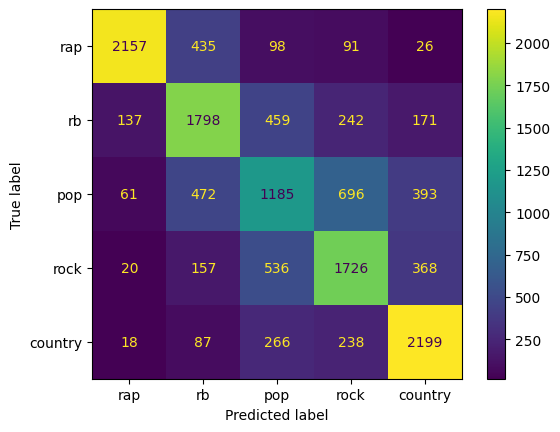

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(predictions.label_ids, preds),
                              display_labels=labels_map)
disp.plot()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(predictions.label_ids, preds, target_names=labels_map))

              precision    recall  f1-score   support

         rap       0.90      0.77      0.83      2807
          rb       0.61      0.64      0.62      2807
         pop       0.47      0.42      0.44      2807
        rock       0.58      0.61      0.60      2807
     country       0.70      0.78      0.74      2808

    accuracy                           0.65     14036
   macro avg       0.65      0.65      0.65     14036
weighted avg       0.65      0.65      0.65     14036



In [ ]:
trainer.save_model(MODEL_DIR + '/best')